In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import matplotlib as pt

plt.rcParams['figure.dpi'] = 150

co2_df = pd.read_csv('./data/CO2_monthly.csv')
co2_df.index = pd.to_datetime(co2_df['Date'])
co2_df = co2_df['Interpolated'].rename('Observed').to_frame()


In [8]:
# root mean squared error
def rmse(predicted, actual):
    diffs = predicted - actual
    return math.sqrt((diffs ** 2).sum()) / len(diffs.dropna())

#Autoregression formula
# takes data and number of observations to use
def train_ar(values, order):
    target_vector = np.array(values[order:])
    lagged_values = []
    for i in range(len(values) - order):
        lagged_values.append(values[i:i+order]) 
    design_matrix = np.array(lagged_values)
    return np.linalg.inv(design_matrix.transpose() @ design_matrix) @ design_matrix.transpose() @ target_vector

# Prediction function, use coeffs from AR function and observed data
def predict(coeffs, data):
    predicted_values = [math.nan] * len(coeffs)
    for i in range(len(coeffs), len(data)):
        predicted_values.append(np.dot(coeffs, data[i-len(coeffs):i]))
    return np.array(predicted_values)

Do an AR prediction for the CO2 data.  
Start by doing the PACF calculation to guide the choice of the order for the AR(?)

c:\Users\hugho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


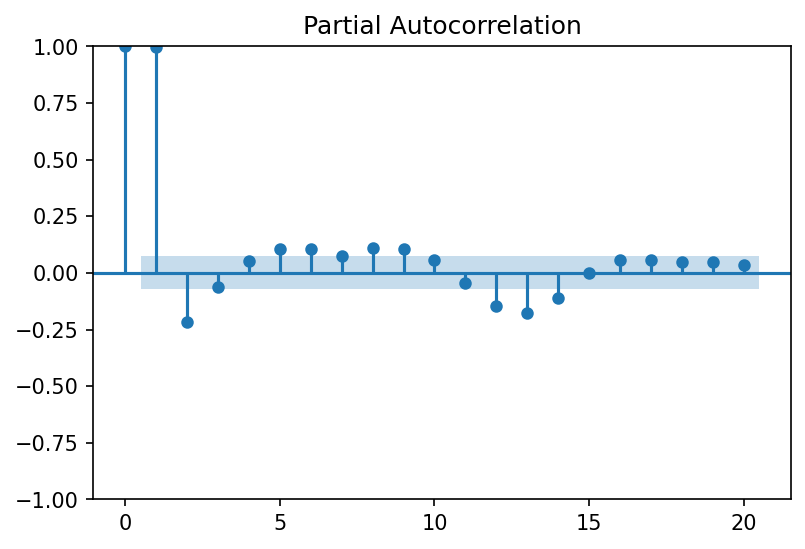

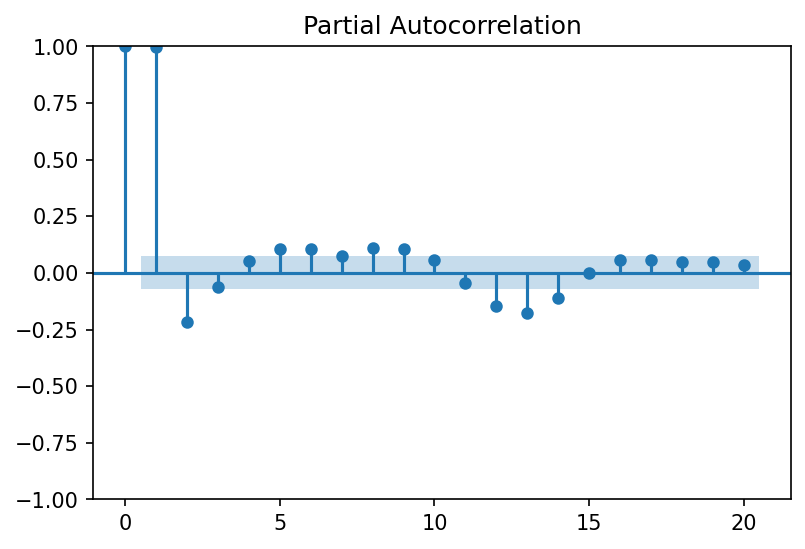

In [9]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(co2_df['Observed'], lags=20)

Argument for for a simple AR(2) model but also 13 shows up so go with that, make it more interesting.  

In [10]:
# using 13 data points to get 13 coefficients
coeffs = train_ar(co2_df['Observed'], 13)

# get predicted observations using predict func
ar_predict_whole = predict(coeffs, co2_df['Observed'])

# get RMSE errors
ar_rmse = rmse(ar_predict_whole, co2_df['Observed'])
print ('RMSE FROM AR(13): ', ar_rmse)

RMSE FROM AR(13):  0.013426979139796524


**Now decompose using the statsmodel STL function**  

*tsa means time series analysis module*

In [11]:
from statsmodels.tsa.seasonal import STL

co2_decomp = STL(co2_df['Observed']).fit()

co2_trend = co2_decomp.trend
co2_seasonal = co2_decomp.seasonal
co2_resid = co2_decomp.resid

<AxesSubplot:xlabel='Date'>

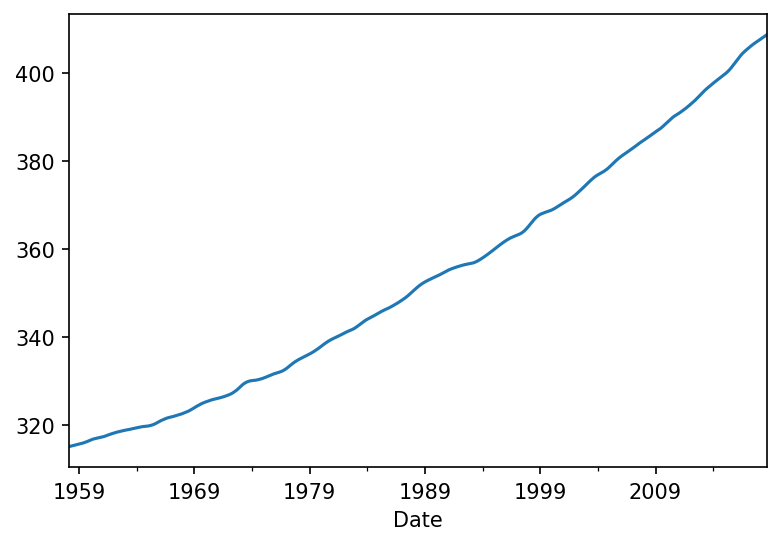

In [12]:
co2_trend.plot()

<AxesSubplot:xlabel='Date'>

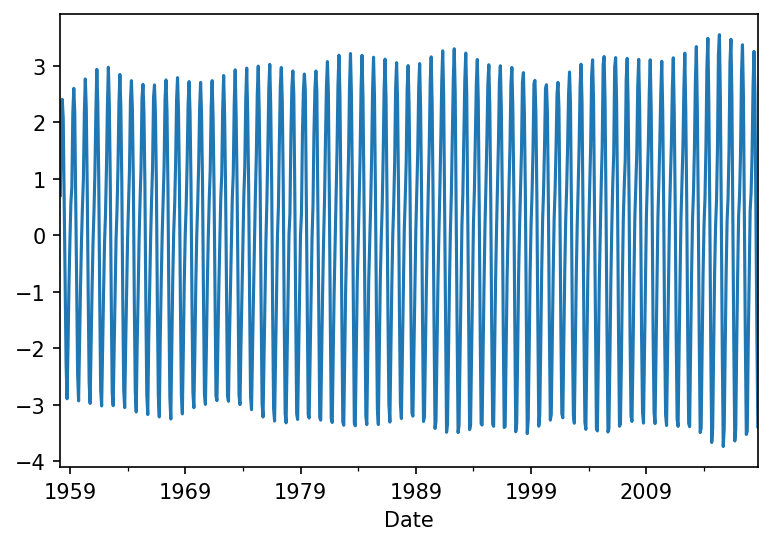

In [13]:
co2_seasonal.plot()

<AxesSubplot:xlabel='Date'>

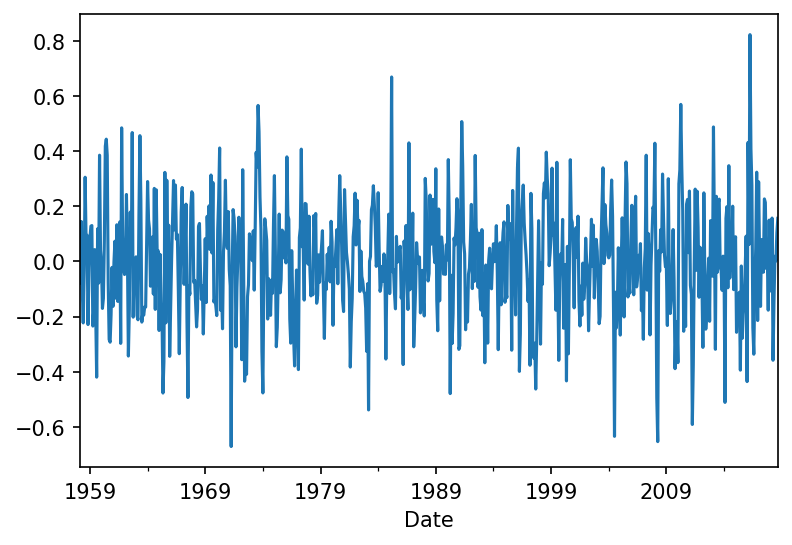

In [14]:
co2_resid.plot()

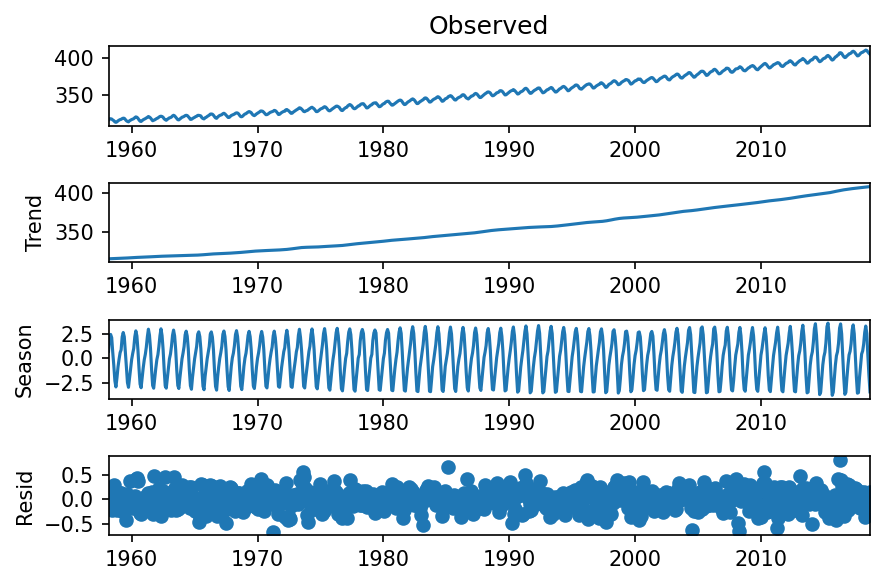

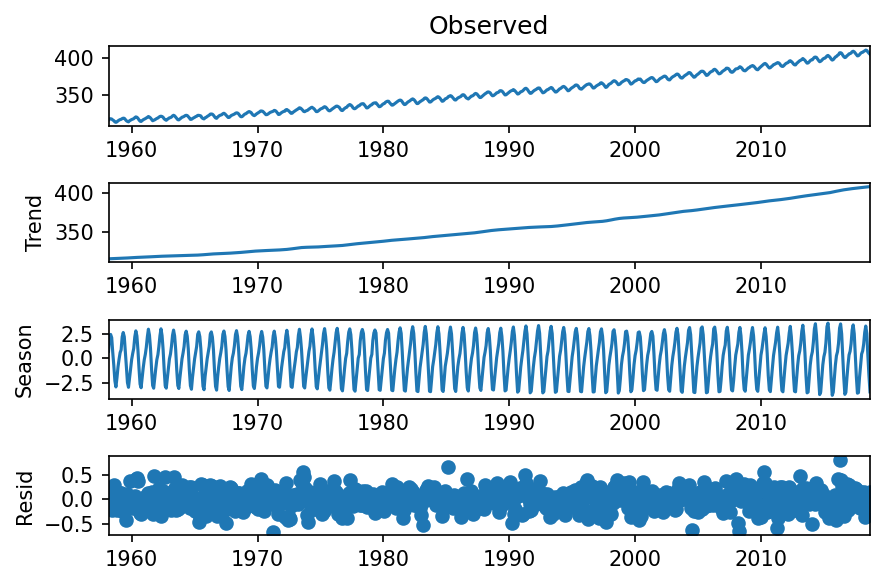

In [15]:
co2_decomp.plot()

Now predict 1 by 1 starting with trend.  


### Predict Trend w. Naive Differences
Do naive diftferences as explained before. 

Take shift(1) and add it to shift(1) minus shift(2)  

Because shift(1) minus shift(2) is the differences from the one before

<AxesSubplot:xlabel='Date'>

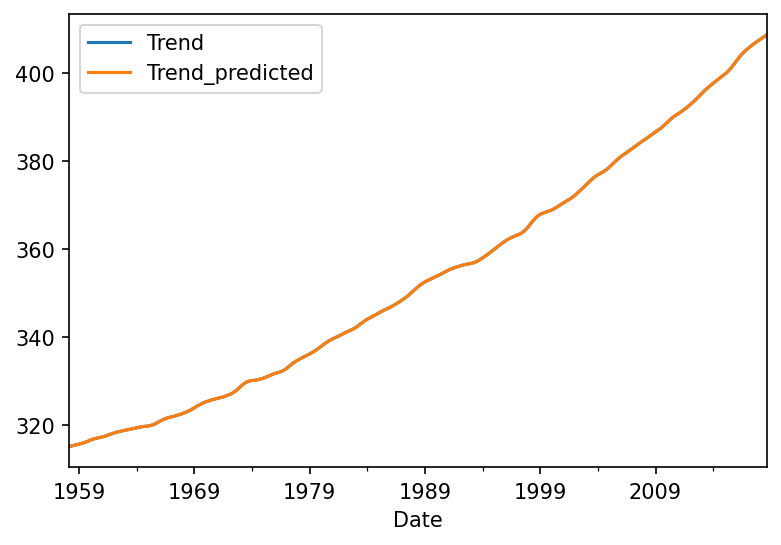

In [16]:
predicted_trend = 2*co2_trend.shift(1) - co2_trend.shift(2)

frame = {'Trend': co2_trend, 'Trend_predicted': predicted_trend }
trend_df = pd.DataFrame(frame)
trend_df.plot()

### Predict Seasonal w. Seasonal Naive Prediction


Use seasonal naive prediction.  

Similar to naive except use the lags by the period of seasonality instead of just the one before. 

In the case of this data the lag is 12.  

<AxesSubplot:xlabel='Date'>

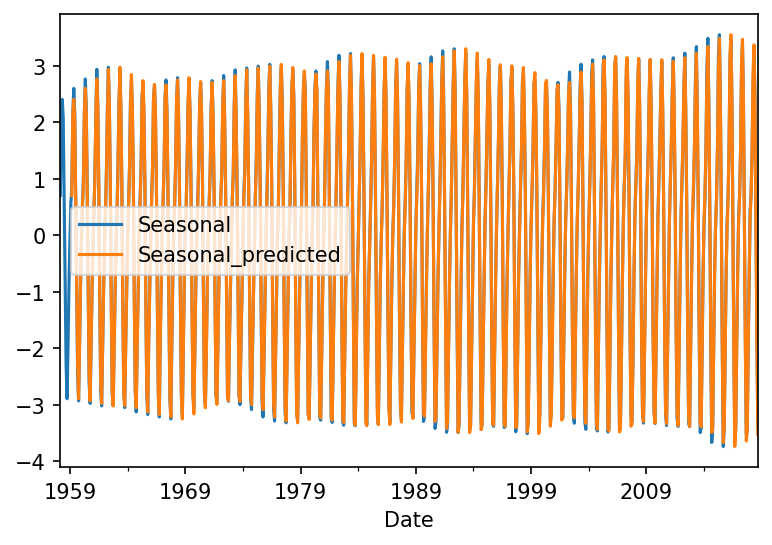

In [17]:
predicted_seasonal = co2_seasonal.shift(12)
frame = {'Seasonal': co2_seasonal, 'Seasonal_predicted': predicted_seasonal}

seasonal_df = pd.DataFrame(frame)

seasonal_df.plot()

### Predict Residual using AR(p)

Use AR model  

Plot a PCF to inform our model choice

c:\Users\hugho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


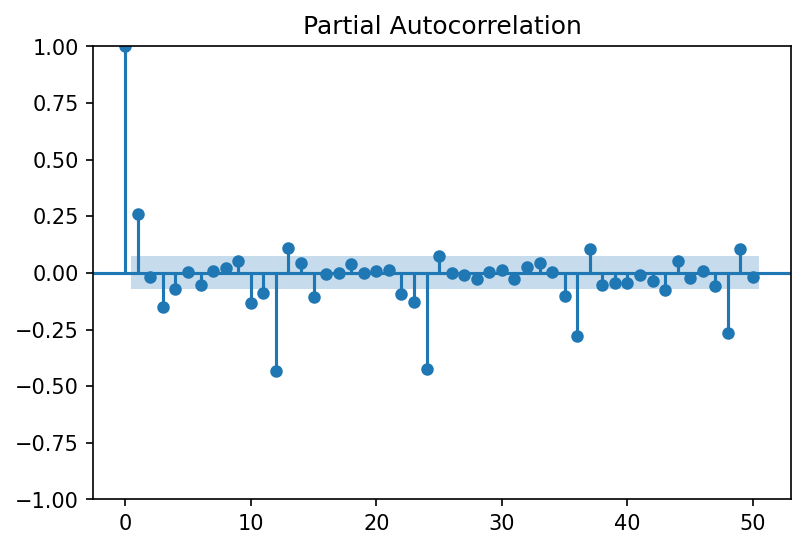

In [18]:
from matplotlib import pyplot

plot_pacf(co2_resid, lags=50)
pyplot.show()

In [19]:
# pick 12 based on chart above
co2_resid_arcoefs = train_ar(co2_resid, 12)
predicted_resid = predict(co2_resid_arcoefs, co2_resid)
co2_resid_arcoefs

array([-0.42832845,  0.0211276 , -0.09759257,  0.02651893, -0.02985018,
       -0.01136896, -0.08089983,  0.01044237, -0.07742919, -0.09437604,
       -0.01472902,  0.21046748])

<AxesSubplot:xlabel='Date'>

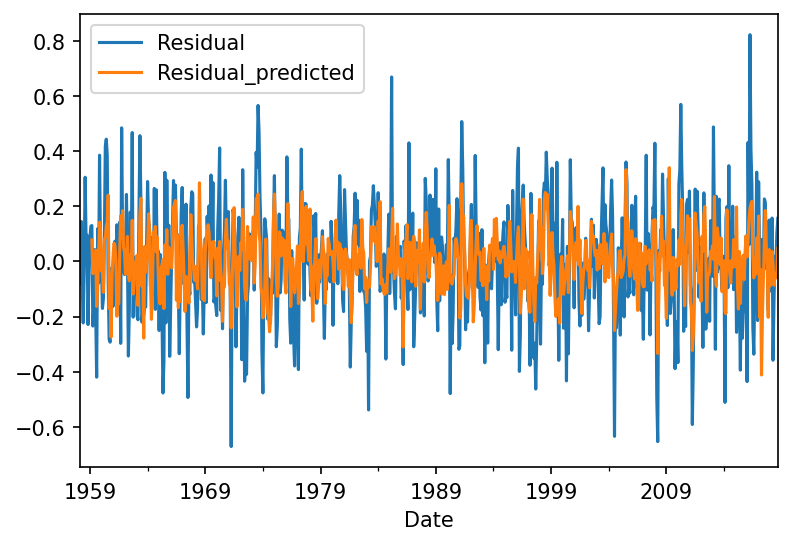

In [20]:
frame = {'Residual': co2_resid, 'Residual_predicted': predicted_resid}
residual_df = pd.DataFrame(frame)
residual_df.plot()

### Check RMSE for each component

In [21]:
trend_rmse = rmse(predicted_trend, co2_trend)
seasonal_rmse = rmse(predicted_seasonal, co2_seasonal)
resid_rmse = rmse(predicted_resid, co2_resid)

print("Component RMSE: trend", trend_rmse, ", seasonal", seasonal_rmse, "resid", resid_rmse)

print("Combined RMSE", rmse(predicted_trend + predicted_seasonal + predicted_resid, co2_df['Observed']))

print("RMSE from AR3(12)", ar_rmse)

Component RMSE: trend 0.00025576245322943807 , seasonal 0.002641919464274233 resid 0.006440743660796805
Combined RMSE 0.006895317789393446
RMSE from AR3(12) 0.013426979139796524


Find that the Combined RMSE is twice as good as the RMSE from AR(13)

<AxesSubplot:xlabel='Date'>

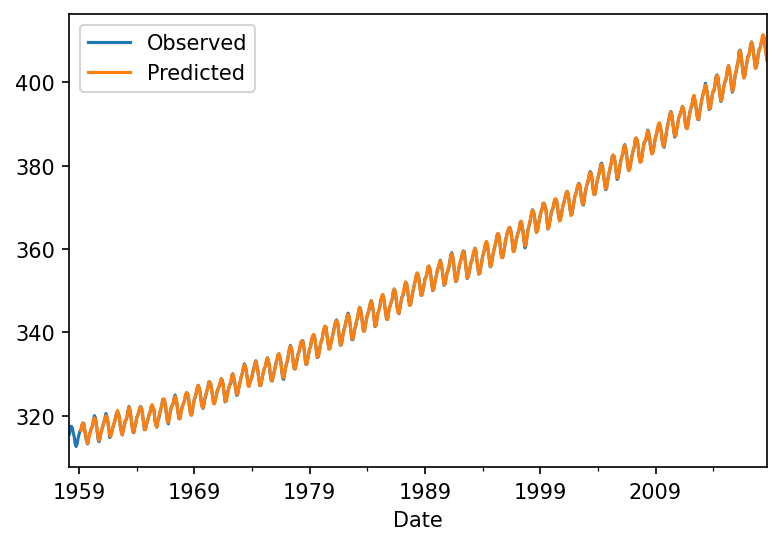

In [22]:
co2_df['Predicted'] = predicted_trend + predicted_seasonal + predicted_resid
co2_df.plot()

## Monte Carlo Trajectory
create trajectories for each component: trend, seasonal, residual

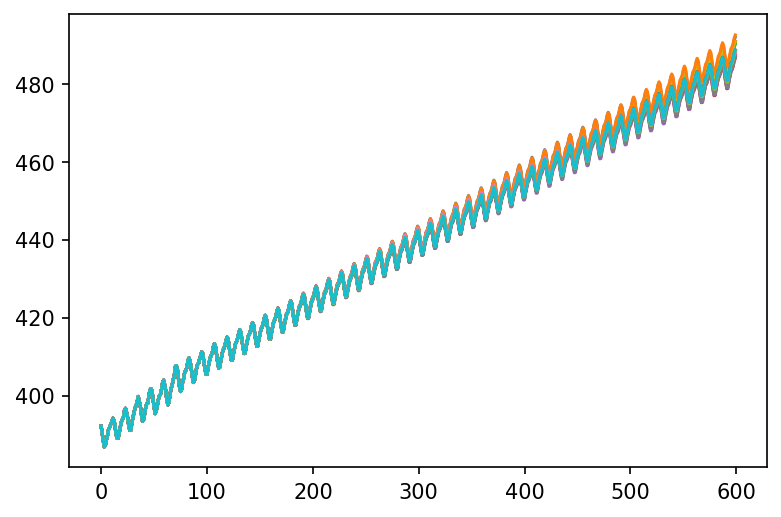

In [23]:
num_samples = 20

trend_trajectories = np.broadcast_to(co2_trend.to_numpy().reshape((-1, 1)), (len(co2_trend), num_samples))

seasonal_trajectories = np.broadcast_to(co2_seasonal.to_numpy().reshape((-1,1)), (len(co2_seasonal), num_samples))

resid_trajectories = np.broadcast_to(co2_resid.to_numpy().reshape((-1, 1)), (len(co2_resid), num_samples))

for i in range(500):
    trend_prediction = 2 * trend_trajectories[-1,:] - trend_trajectories[-2,:]
    next_trend_row = trend_prediction + trend_rmse * np.random.randn(num_samples)
    trend_trajectories = np.append(trend_trajectories, next_trend_row.reshape((1,num_samples)), axis=0)

    seasonal_prediction = seasonal_trajectories[-12,:]
    next_seasonal_row = seasonal_prediction + seasonal_rmse * np.random.randn(num_samples)
    seasonal_trajectories = np.append(seasonal_trajectories, next_seasonal_row.reshape((1,num_samples)), axis=0)

    resid_prediction = co2_resid_arcoefs @ resid_trajectories[-len(co2_resid_arcoefs):,:]
    next_resid_row = resid_prediction + resid_rmse * np.random.randn(num_samples)
    resid_trajectories = np.append(resid_trajectories, next_resid_row.reshape((1,num_samples)), axis=0)

trajectories = trend_trajectories + seasonal_trajectories + resid_trajectories 

_ = plt.plot(trajectories[-600:,:])

Shows what happens with 500 random walks, stays pretty tight but slowly spreads out as it goes  

